In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
# read data
df = pd.read_csv('/Users/LLovemiao/Desktop/CS235-New-York-Airbnb-master/AB_NYC_2019.csv')

# chose interesting features
v_pool = ['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']
df = df[v_pool]
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10


In [8]:
def knnreg(c, feature_col, k = 5):
    data = df.copy()
    data = data.dropna()
    data['distance'] = np.abs(df[feature_col] - c)
    data = data.sort_values('distance')
    knn = data.iloc[:k]
    price_predict = knn['price'].mean()
    return price_predict

for col in ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']:
    data = df[:100].copy()
    data['predicted_price'] = data[col].apply(knnreg, feature_col = col, k = 5)
    data['squared_error'] = (data['price'] - data['predicted_price'])**2
    mse = data['squared_error'].mean()
    rmse = mse**0.5
    print("RMSE for the {} column: {}".format(col, rmse))

RMSE for the latitude column: 105.51724219292316
RMSE for the longitude column: 182.50961180168022
RMSE for the minimum_nights column: 103.75538733000808
RMSE for the number_of_reviews column: 102.97340821785012
RMSE for the reviews_per_month column: 131.25756206786716


In [9]:
from sklearn import preprocessing
cols = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']
data = df[cols].copy()
data = data.dropna()

# Scramble the data into three groups
data_shuffle = data.sample(frac = 1, random_state=0)
n1 = int(len(data)*(0.8))
n2 = int(len(data)*(0.9))

data_train = data_shuffle[:n1]
data_test1 = data_shuffle[n1:n2]
data_test2 = data_shuffle[n2:]

scaler = preprocessing.StandardScaler().fit(data_train)
data_norm_train = pd.DataFrame(scaler.transform(data_train), columns = cols)
data_norm_test1 = pd.DataFrame(scaler.transform(data_test1), columns = cols)
data_norm_test2 = pd.DataFrame(scaler.transform(data_test2), columns = cols)

In [10]:
from sklearn.neighbors import KNeighborsRegressor
factors = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']
target = ['price']
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(data_norm_train[factors], data_norm_train[target])

data_norm_train['predict_price'] = knn_reg.predict(data_norm_train[factors])
data_norm_test1['predict_price'] = knn_reg.predict(data_norm_test1[factors])
data_norm_test2['predict_price'] = knn_reg.predict(data_norm_test2[factors])

In [11]:
from sklearn.metrics import mean_squared_error
rmse1 = mean_squared_error(data_norm_train[target], data_norm_train['predict_price'])**0.5
print('RMSE pf the training data: %.2f' %rmse1)
rmse2 = mean_squared_error(data_norm_test1[target], data_norm_test1['predict_price'])**0.5
print('RMSE pf the test data1: %.2f' %rmse2)
rmse3 = mean_squared_error(data_norm_test2[target], data_norm_test2['predict_price'])**0.5
print('RMSE pf the test data2: %.2f' %rmse3)

RMSE pf the training data: 0.84
RMSE pf the test data1: 1.27
RMSE pf the test data2: 0.96


In [12]:
lst_rmse_train = []
lst_rmse_test1 = []
lst_rmse_test2 = []
for i in range(2, 40):
    knn_reg = KNeighborsRegressor(n_neighbors=i)
    knn_reg.fit(data_norm_train[factors], data_norm_train[target])
    data_norm_train['predict_price'] = knn_reg.predict(data_norm_train[factors])
    data_norm_test1['predict_price'] = knn_reg.predict(data_norm_test1[factors])
    data_norm_test2['predict_price'] = knn_reg.predict(data_norm_test2[factors])
    
    rmse1 = mean_squared_error(data_norm_train[target], data_norm_train['predict_price'])**0.5
    rmse2 = mean_squared_error(data_norm_test1[target], data_norm_test1['predict_price'])**0.5
    rmse3 = mean_squared_error(data_norm_test2[target], data_norm_test2['predict_price'])**0.5

    lst_rmse_train.append(rmse1)
    lst_rmse_test1.append(rmse2)
    lst_rmse_test2.append(rmse3)

Text(0, 0.5, 'RMSE')

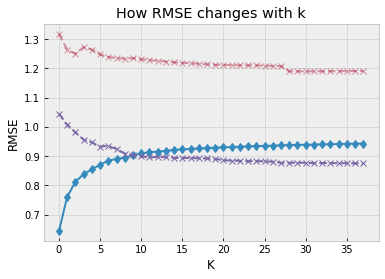

In [16]:
import matplotlib.style as psl
psl.use('bmh')
plt.plot(lst_rmse_train, linestyle = '-', marker = 'd')
plt.plot(lst_rmse_test1, linestyle = '--', marker = 'x', alpha = 0.4)
plt.plot(lst_rmse_test2, linestyle = '--', marker = 'x', alpha = 1)
plt.title("How RMSE changes with k")
plt.xlabel("K")
plt.ylabel("RMSE")

In [15]:
my = np.array([40.76404, -73.98933, 7, 0, 0, 9999]).reshape(1, -1)
a = pd.DataFrame(scaler.transform(my), columns = cols)
a = a.drop('price', axis = 1)
predicted_price_scaled = knn_reg.predict(a)

mu = data_train['price'].describe()['mean']
std = data_train['price'].describe()['std']
predicted_price_dollar = predicted_price_scaled*std + mu
print('\n predict my house rent price, here are my house attributes:')
for i in range(len(factors)):
    print('    ', factors[i], ':', my[0][i])
print('predicted price is : ', float(predicted_price_dollar))


 predict my house rent price, here are my house attributes:
     latitude : 40.76404
     longitude : -73.98933
     minimum_nights : 7.0
     number_of_reviews : 0.0
     reviews_per_month : 0.0
predicted price is :  76.12714891333094
